In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler

from datetime import datetime
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('/home/mikhail/Downloads/Hackathon/train_dataset_Самолет.csv', low_memory = False)
data.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


### EDA

Проведя предварительный разведывательный анализ, мы выяснили несколько важных аспектов:

1) Таблица довольно сильно разряженна, очень много пропусков, просто выбросить наны не получится 
2) Поведение колонок разнится значительным образом, есть как числовые, так и объектные, и категориальные переменные. В связи с высоким числом пропусков были подобраны несколько эвристик и установлены к ним необходимые пороговые значения, основываясь только преставленными данными. Средни них: число уникальных значения в столбце, общее количество не нановых значений, строка/число и т.д.
3) Некоторые колонки сильно скоррелированны между собой, бороться с ними нам поможет регуляризация 
4) Доля пользователей, купивших машиноместо состалвяет примерно 3.8% от общего числа уникальных пользователей - классы не сбалансированны
5) Практически все наблюденя имеют более чем одно уникальное значение, это говорит о необходимости воспользоваться кросс-валидацией дабы избежать "перетекания" данных. 
6) Дата преобразована в календарные фичи для потенциальной возможности отлавливать эффект от сезонности 

In [3]:
data.shape

(14456, 2666)

In [4]:
data.isna().sum().describe()

count     2666.000000
mean     12336.923481
std       3713.753371
min          0.000000
25%      12637.000000
50%      14143.000000
75%      14403.000000
max      14456.000000
dtype: float64

In [5]:
data.dropna()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663


In [6]:
descr_info = data.describe()
descr_info

,client_id,target,col1,col2,col3,col4,col5,col6,col7,col8,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
count,14456.000000,14456.000000,3.000000,6.000000,12.000000,19.000000,1.0,1.0,3.000000e+00,8.000000e+00,...,6.207000e+03,6.207000e+03,6.207000e+03,5.060000e+02,5.060000e+02,5.060000e+02,8.036000e+03,8.036000e+03,8.036000e+03,14456.000000
mean,2853.066270,0.030160,0.333333,0.500000,0.306548,0.346140,7464071.0,7464071.0,4.762016e+06,4.127563e+06,...,6.951439e+06,6.843002e+06,6.896837e+06,7.042210e+06,7.025990e+06,7.034100e+06,6.934524e+06,6.806725e+06,6.869273e+06,0.258330
std,1957.002315,0.171035,0.577350,0.547723,0.460514,0.452933,NaN,NaN,2.395190e+06,1.430218e+06,...,4.539805e+06,4.509677e+06,4.509058e+06,5.162596e+06,5.160387e+06,5.160985e+06,4.354458e+06,4.315602e+06,4.314412e+06,0.006802
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7464071.0,7464071.0,2.900000e+06,2.900000e+06,...,3.000000e+05,1.000000e+05,3.000000e+05,4.692700e+05,4.692700e+05,4.692700e+05,3.000000e+05,1.000000e+05,3.000000e+05,0.230229
25%,1186.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7464071.0,7464071.0,3.410988e+06,3.666482e+06,...,4.316300e+06,4.248000e+06,4.300000e+06,4.413816e+06,4.413816e+06,4.413816e+06,4.334639e+06,4.276000e+06,4.303000e+06,0.256261
50%,2568.000000,0.000000,0.000000,0.500000,0.000000,0.000000,7464071.0,7464071.0,3.921976e+06,3.921976e+06,...,6.240000e+06,6.164000e+06,6.224000e+06,6.322850e+06,6.322850e+06,6.322850e+06,6.244578e+06,6.146774e+06,6.225550e+06,0.256261
75%,4258.250000,0.000000,0.500000,1.000000,0.758929,0.839286,7464071.0,7464071.0,5.693024e+06,3.958614e+06,...,8.801262e+06,8.649254e+06,8.748625e+06,9.110361e+06,9.110361e+06,9.110361e+06,8.769750e+06,8.619750e+06,8.700000e+06,0.257217
max,8302.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7464071.0,7464071.0,7.464071e+06,7.464071e+06,...,9.800000e+07,9.800000e+07,9.800000e+07,9.524250e+07,9.524250e+07,9.524250e+07,9.800000e+07,9.800000e+07,9.800000e+07,0.339800


In [7]:
col_info = pd.DataFrame(data.nunique()).rename(columns = {0: 'n_values'})
uniq_values = []
types = []
count_values = []
for column in data.columns:

    non_none_values = data[column].dropna()
    data_type = non_none_values.dtype
    uniq_values.append(data[column].unique())
    count_values.append(len(non_none_values))
    types.append(data_type)

col_info['uniq_values'] = uniq_values
col_info['data_type'] = types
col_info['values_count'] = count_values
col_info

,n_values,uniq_values,data_type,values_count
report_date,25,"[2022-11-01, 2022-05-01, 2022-09-01, 2022-08-0...",object,14456
client_id,4817,"[1, 5, 6, 7, 8, 10, 16, 17, 18, 19, 21, 22, 23...",int64,14456
target,2,"[0, 1]",int64,14456
col1,2,"[nan, 1.0, 0.0]",float64,3
col2,2,"[nan, 0.0, 1.0]",float64,6
...,...,...,...,...
col2659,393,"[nan, 8284916.0, 9147105.0, 6633000.0, 3000000...",float64,506
col2660,1885,"[nan, 7616803.0, 10850000.0, 4818792.0, 530000...",float64,8036
col2661,1894,"[nan, 7616803.0, 10850000.0, 4818792.0, 506500...",float64,8036
col2662,1942,"[nan, 7616803.0, 10850000.0, 4818792.0, 518250...",float64,8036


In [8]:
cols_to_drop = col_info[col_info.n_values == 0].index.to_list()

In [85]:
cols_dummies = col_info[(col_info.n_values <= 20)&(col_info.values_count < 100)].index.to_list()#.values_count.plot()

,n_values,uniq_values,data_type,values_count
col1,2,"[nan, 1.0, 0.0]",float64,3
col2,2,"[nan, 0.0, 1.0]",float64,6
col3,3,"[nan, 0.0, 0.6785714285714286, 1.0]",float64,12
col4,4,"[nan, 0.0, 0.6785714285714286, 1.0, 0.21951219...",float64,19
col5,1,"[nan, 7464071.0]",float64,1
...,...,...,...,...
col2538,0,[nan],float64,0
col2539,0,[nan],float64,0
col2540,0,[nan],float64,0
col2541,0,[nan],float64,0


In [ ]:
cols_dummies = col_info[(col_info.n_values <= 20)&(col_info.values_count < 100)].index.to_list()

In [16]:
objects_cols = col_info[col_info.data_type == 'object'].index#.iloc[350]['uniq_values']

Index(['report_date', 'col49', 'col50', 'col51', 'col52', 'col53', 'col54',
       'col55', 'col56', 'col57',
       ...
       'col1653', 'col1654', 'col2191', 'col2192', 'col2193', 'col2194',
       'col2195', 'col2196', 'col2197', 'col2198'],
      dtype='object', length=351)

In [111]:
fil_with_mean = col_info[(col_info.n_values >= 20)].index.to_list() #data['col142'].value_counts()

<Axes: >

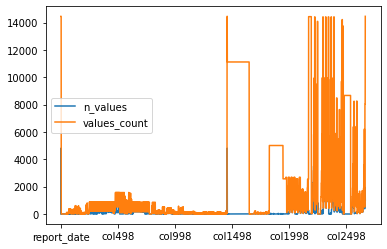

In [18]:
col_info.plot()

In [19]:
data.client_id.nunique()

4817

In [32]:
data[data.target == 1].client_id.nunique()

183

In [21]:
print(f'Conversion rate  = {round(183/ 4817*100,2)}%')

Conversion rate  = 3.8%


In [20]:
target_one  = data[data.target == 1].client_id.unique()
target_zero  = data[data.target == 0].client_id.unique()
one_and_zero = data[(data.client_id.isin(target_one))&(data.client_id.isin(target_zero))].groupby(['client_id','target']).agg({'report_date':list}).\
    sort_values(['client_id','target']).reset_index()
one_and_zero['max_date'] = one_and_zero['report_date'].apply(lambda x: max(x))
one = one_and_zero[one_and_zero.target == 1] 
zero = one_and_zero[one_and_zero.target == 0]
check = one.merge(zero, on = 'client_id')
check['is_one_later'] = check['max_date_x'] > check['max_date_y']
check

,client_id,target_x,report_date_x,max_date_x,target_y,report_date_y,max_date_y,is_one_later
0,51,1,"[2022-08-01, 2022-09-01, 2022-10-01]",2022-10-01,0,"[2022-04-01, 2022-03-01, 2021-12-01]",2022-04-01,True
1,264,1,"[2022-10-01, 2022-09-01, 2022-08-01]",2022-10-01,0,"[2021-11-01, 2021-06-01, 2022-01-01, 2022-06-0...",2022-06-01,True
2,300,1,"[2021-10-01, 2021-08-01, 2021-09-01]",2021-10-01,0,"[2021-03-01, 2021-05-01]",2021-05-01,True
3,354,1,[2023-02-01],2023-02-01,0,"[2022-10-01, 2022-09-01]",2022-10-01,True
4,449,1,"[2022-03-01, 2022-02-01, 2022-04-01]",2022-04-01,0,[2021-12-01],2021-12-01,True
...,...,...,...,...,...,...,...,...
68,5234,1,"[2021-07-01, 2021-08-01]",2021-08-01,0,"[2021-05-01, 2021-02-01]",2021-05-01,True
69,5768,1,"[2022-09-01, 2022-11-01, 2022-10-01]",2022-11-01,0,"[2022-07-01, 2022-01-01, 2022-08-01]",2022-08-01,True
70,6031,1,"[2022-12-01, 2022-11-01, 2022-10-01]",2022-12-01,0,"[2022-08-01, 2022-07-01]",2022-08-01,True
71,6089,1,"[2021-12-01, 2022-02-01, 2022-01-01]",2022-02-01,0,[2021-09-01],2021-09-01,True


In [58]:
corr_mtx = data.corr()
corr_mtx.head()

/tmp/ipykernel_162527/2382451409.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mtx = data.corr()


,client_id,target,col1,col2,col3,col4,col5,col6,col7,col8,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
client_id,1.000000,0.047855,-0.978858,-0.251378,-0.227932,0.036716,NaN,NaN,0.976978,0.104332,...,0.022723,0.022888,0.022731,0.025043,0.027251,0.026150,0.024646,0.021308,0.022768,0.054664
target,0.047855,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.084717,0.073289,0.079170,0.072918,0.073696,0.073314,0.082777,0.070938,0.076885,0.090878
col1,-0.978858,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.810468
col2,-0.251378,NaN,1.000000,1.000000,0.863297,0.863297,NaN,NaN,NaN,NaN,...,0.584735,0.584735,0.584735,1.000000,1.000000,1.000000,0.584735,0.584735,0.584735,-0.808852
col3,-0.227932,NaN,1.000000,0.863297,1.000000,0.990539,NaN,NaN,NaN,NaN,...,-0.094287,-0.094287,-0.094287,0.989761,0.989761,0.989761,-0.094287,-0.094287,-0.094287,-0.370320


### Baseline 

В качестве бейзлайна была выбрана линейная модель с регуляризацией L1 в силу специфики данных. В качестве основных метрик для оценки работы алгоритма выводястся матрица смежности, рок аук (+ скор), поклассовые precision и recall. Модель довольно примитивная, но даже ей демонстрируются результаты лучше, чем примитивным гаданием.  

In [113]:
# label_encoder.fit_transform(data['col2195'])

def extract_time_features(date_str):

    # Convert the date string to a datetime object
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')

    # Extract year, month, and day
    year = date_obj.year
    month = date_obj.month
    #day = date_obj.day

    # Extract the number of the week in the year
    week_number = date_obj.strftime('%U')

    return year, month,  week_number

def transform_data(df, cols_to_drop, objects_cols, cols_dummies, fil_with_mean):

    data = df.drop(['target', 'report_date'], axis=1)

    data['year'] = df['report_date'].apply(lambda x: extract_time_features(x)[0])
    data['month'] = df['report_date'].apply(lambda x: extract_time_features(x)[1])
    #data['day'] = df['report_date'].apply(lambda x: extract_time_features(x)[2])
    data['week_number'] = df['report_date'].apply(lambda x: extract_time_features(x)[2])

    label_encoder = LabelEncoder()
    data = data.drop(cols_to_drop, axis = 1 )
    
    for col in objects_cols:

        if col in data.columns:
            data[col] = label_encoder.fit_transform(data[col])

    for col in cols_dummies:

        if (col in data.columns) and (col not in objects_cols):
            data[col] = data[col].apply(lambda x: 0 if str(x) == 'nan' else 1)

    for col in fil_with_mean:

        if (col in data.columns) and (col not in objects_cols) and (col not in cols_dummies):
            data[col] = data[col].apply(lambda x: 0 if str(x) == 'nan' else  data[col].mean())   


    # pd.get_dummies(data, columns=['col2195'], prefix=['col2195'])
    
    return data


X_check = transform_data(data, cols_to_drop, objects_cols, cols_dummies, fil_with_mean).dropna(axis=1)
X_check

,client_id,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col2657,col2658,col2659,col2660,col2661,col2662,col2663,year,month,week_number
0,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.25833,2022,11,44
1,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,6.934524e+06,6.806725e+06,6.869273e+06,0.25833,2022,11,44
2,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.25833,2022,5,18
3,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.25833,2022,9,35
4,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.25833,2022,8,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.25833,2022,7,26
14452,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.25833,2022,9,35
14453,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.25833,2022,2,05
14454,2853.06627,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.25833,2021,8,31


In [102]:
X_check.corr()

/tmp/ipykernel_162527/4231945723.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_check.corr()


,client_id,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col2195,col2196,col2197,col2198,col2471,col2472,col2477,col2663,year,month
client_id,1.000000,0.012969,0.015537,0.017490,0.016982,-0.000315,-0.000315,-0.007436,0.006172,-0.000315,...,-0.060577,-0.068475,-0.022366,-0.071480,0.010716,0.005976,0.002551,0.054664,0.109223,-0.021781
col1,0.012969,1.000000,0.707033,0.499844,0.397140,-0.000120,-0.000120,-0.000208,-0.000339,-0.000120,...,-0.039701,-0.034560,-0.112750,-0.033794,-0.000379,-0.000432,-0.000415,0.003126,0.000653,0.013578
col2,0.015537,0.707033,1.000000,0.706960,0.561699,-0.000169,-0.000169,-0.000294,-0.000479,-0.000169,...,-0.026761,-0.022948,-0.079259,-0.022375,-0.000536,-0.000611,-0.000587,0.005166,0.000924,0.017405
col3,0.017490,0.499844,0.706960,1.000000,0.794527,-0.000240,-0.000240,-0.000415,-0.000678,-0.000240,...,-0.037334,-0.032044,-0.055384,-0.031241,-0.000758,-0.000865,-0.000831,0.041769,0.009503,0.017622
col4,0.016982,0.397140,0.561699,0.794527,1.000000,-0.000302,-0.000302,-0.000523,-0.000854,-0.000302,...,-0.041171,-0.049359,-0.043402,-0.048171,-0.000954,-0.001088,-0.001046,0.060232,0.021191,0.010927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
col2472,0.005976,-0.000432,-0.000611,-0.000865,-0.001088,-0.000250,-0.000250,-0.000432,-0.000706,-0.000250,...,-0.016100,-0.013228,0.001400,-0.012788,0.876967,1.000000,0.960736,0.013581,0.032860,-0.018792
col2477,0.002551,-0.000415,-0.000587,-0.000831,-0.001046,-0.000240,-0.000240,-0.000415,-0.000678,-0.000240,...,0.003720,0.004221,0.001345,0.004311,0.821451,0.960736,1.000000,0.011987,0.029994,-0.016096
col2663,0.054664,0.003126,0.005166,0.041769,0.060232,-0.002530,-0.002530,-0.003032,0.001110,-0.002530,...,-0.130072,-0.142556,-0.031211,-0.141379,0.007777,0.013581,0.011987,1.000000,0.136058,-0.046472
year,0.109223,0.000653,0.000924,0.009503,0.021191,0.000377,0.000377,0.000653,0.001066,0.000377,...,-0.081586,-0.108678,-0.009432,-0.108340,0.032616,0.032860,0.029994,0.136058,1.000000,-0.536453


Accuracy: 0.8827800829875518
Confusion Matrix:
 [[2534  271]
 [  68   19]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94      2805
           1       0.07      0.22      0.10        87

    accuracy                           0.88      2892
   macro avg       0.52      0.56      0.52      2892
weighted avg       0.95      0.88      0.91      2892



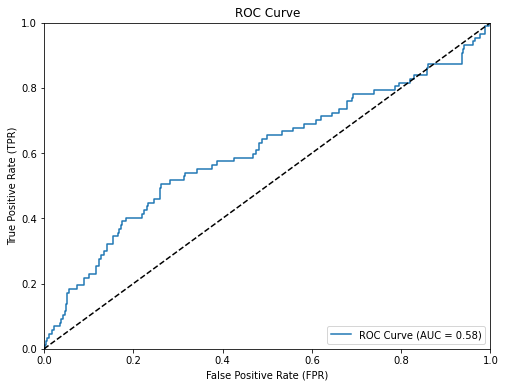

0.601528469276948
Accuracy: 0.7881824464409123
Confusion Matrix:
 [[2244  561]
 [  52   37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88      2805
           1       0.06      0.42      0.11        89

    accuracy                           0.79      2894
   macro avg       0.52      0.61      0.49      2894
weighted avg       0.95      0.79      0.86      2894



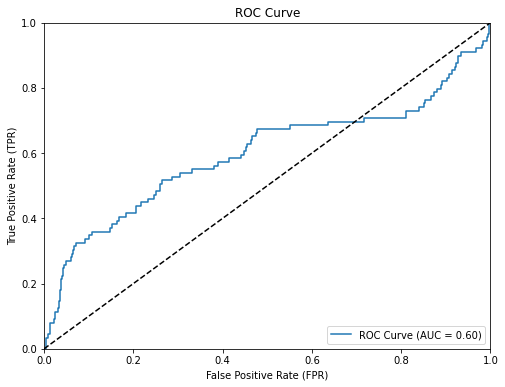

0.598041218530313
Accuracy: 0.8812326869806094
Confusion Matrix:
 [[2529  273]
 [  70   16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94      2802
           1       0.06      0.19      0.09        86

    accuracy                           0.88      2888
   macro avg       0.51      0.54      0.51      2888
weighted avg       0.95      0.88      0.91      2888



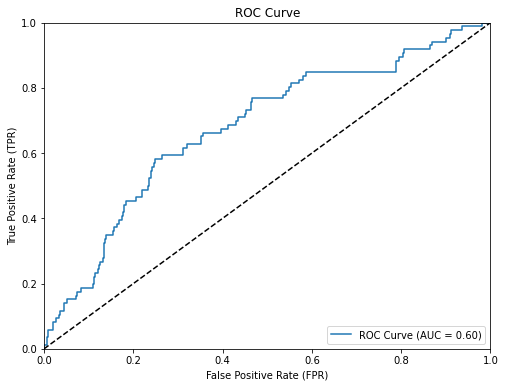

0.6780206829009179
Accuracy: 0.8060836501901141
Confusion Matrix:
 [[2297  508]
 [  53   35]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      2805
           1       0.06      0.40      0.11        88

    accuracy                           0.81      2893
   macro avg       0.52      0.61      0.50      2893
weighted avg       0.95      0.81      0.87      2893



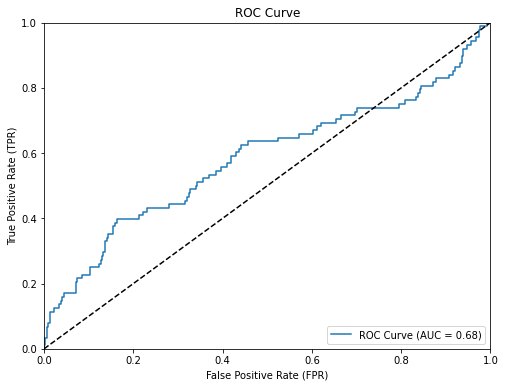

0.5831550802139037
Accuracy: 0.7732779508480443
Confusion Matrix:
 [[2190  613]
 [  42   44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      2803
           1       0.07      0.51      0.12        86

    accuracy                           0.77      2889
   macro avg       0.52      0.65      0.49      2889
weighted avg       0.95      0.77      0.85      2889



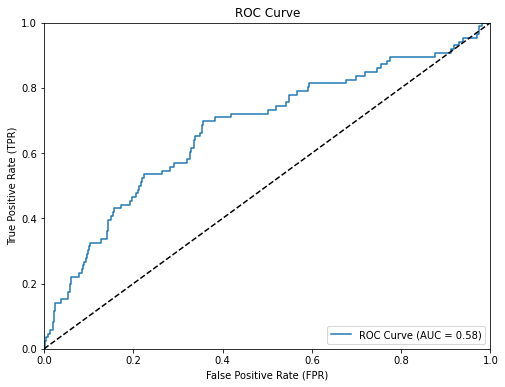

0.6749993777431158


In [115]:
# pd.DataFrame(objects_cols).rename(columns = {0: 'col_name'}).to_parquet('/home/mikhail/Downloads/Hackathon/objects.parquet')
groups = data['client_id']

# Создайте объект StratifiedGroupKFold и задайте количество фолдов
n_splits = 5  # Задайте нужное количество фолдов
sgkf = StratifiedGroupKFold(n_splits=n_splits)

# Проходите по каждому фолду
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X_check, y, groups)):
    # Далее вы можете использовать train_idx и val_idx для разделения данных на обучающий и валидационный фолд
    train_data = X_check.iloc[train_idx]
    val_data = X_check.iloc[val_idx]

    scaler = StandardScaler()

    X_train = scaler.fit_transform(train_data) # выбери другое (например среднее)
    y_train = y[train_idx]#train_data['target']
    
    X_test = scaler.fit_transform(val_data)#.drop(need_columns, axis=1).fillna(-404) # выбери другое (например среднее)
    y_test = y[val_idx]#val_data['target']

    class_weights = {0: 5, 1: 95}

    # Create and train a logistic regression model with custom class weights
    model = LogisticRegression(class_weight=class_weights, solver='liblinear', max_iter=1000, penalty='l1')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion)
    print("Classification Report:\n", classification_rep)

    y_probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    roc_auc = roc_auc_score(y_test, y_probabilities)
    print(roc_auc)

In [122]:
data_andrew = pd.read_pickle('/home/mikhail/Downloads/Hackathon/data.pickle').fillna(-404)
data_andrew

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2658,col2659,col2660,col2661,col2662,col2663,noise_5,noise_05,target_2,mnth
0,2022-11-01,1,0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,-404.0,-404.0,-404.0,0.256261,0,0.882691,0,0.708670
1,2022-11-01,5,0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,7616803.0,7616803.0,7616803.0,0.256261,0,0.882691,0,0.708670
2,2022-05-01,6,0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,-404.0,-404.0,-404.0,0.256261,2,0.882691,0,-0.801144
3,2022-09-01,7,0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,-404.0,-404.0,-404.0,0.258682,3,0.882691,0,-0.210796
4,2022-08-01,8,0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,-404.0,-404.0,-404.0,0.254164,3,0.882691,0,-0.653644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,2022-07-01,1241,0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,-404.0,-404.0,-404.0,0.276902,2,0.882691,0,-0.936457
14452,2022-09-01,1969,1,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,-404.0,-404.0,-404.0,0.260516,2,0.882691,1,-0.210796
14453,2022-02-01,7116,1,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,-404.0,-404.0,-404.0,0.260005,0,0.882691,1,0.540302
14454,2021-08-01,7117,0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,-404.0,...,-404.0,-404.0,-404.0,-404.0,-404.0,0.256261,1,0.882691,0,-0.653644


Accuracy: 0.8409405255878285
Confusion Matrix:
 [[2385  420]
 [  40   47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      2805
           1       0.10      0.54      0.17        87

    accuracy                           0.84      2892
   macro avg       0.54      0.70      0.54      2892
weighted avg       0.96      0.84      0.89      2892



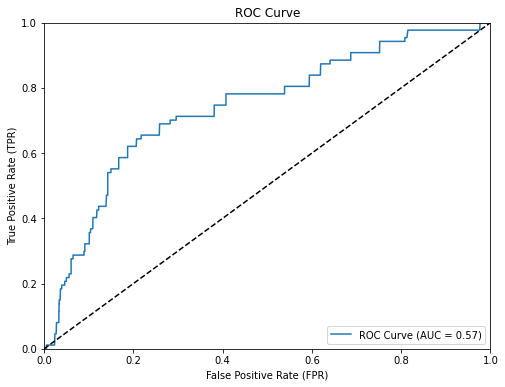

0.7408486487593992
Accuracy: 0.8883897719419489
Confusion Matrix:
 [[2523  282]
 [  41   48]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      2805
           1       0.15      0.54      0.23        89

    accuracy                           0.89      2894
   macro avg       0.56      0.72      0.58      2894
weighted avg       0.96      0.89      0.92      2894



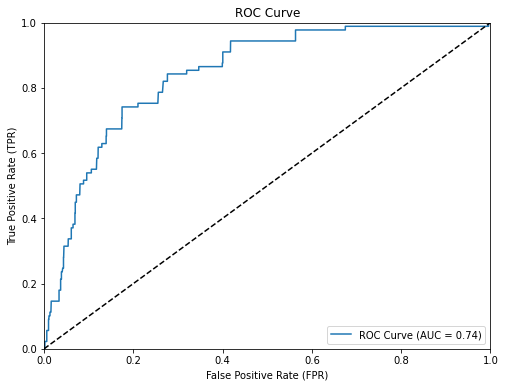

0.8436279516914018
Accuracy: 0.8116343490304709
Confusion Matrix:
 [[2302  500]
 [  44   42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      2802
           1       0.08      0.49      0.13        86

    accuracy                           0.81      2888
   macro avg       0.53      0.65      0.51      2888
weighted avg       0.95      0.81      0.87      2888



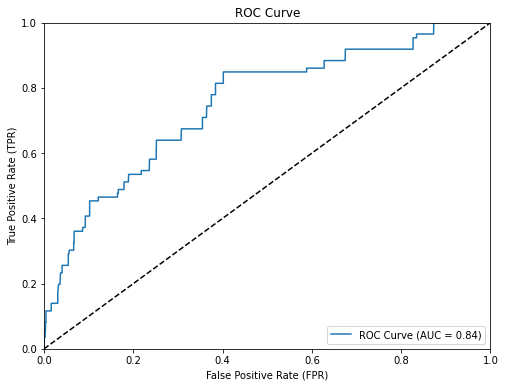

0.7505083578175058
Accuracy: 0.8347735914275838
Confusion Matrix:
 [[2376  429]
 [  49   39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91      2805
           1       0.08      0.44      0.14        88

    accuracy                           0.83      2893
   macro avg       0.53      0.65      0.52      2893
weighted avg       0.95      0.83      0.89      2893



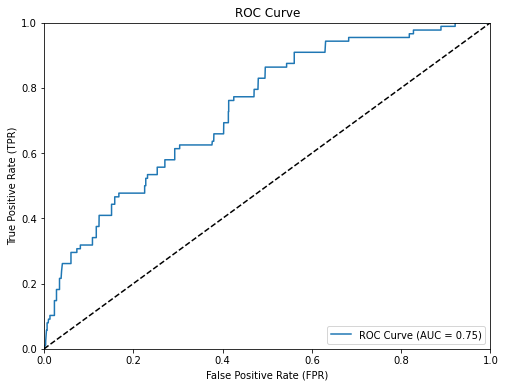

0.7336857883649328
Accuracy: 0.8016614745586709
Confusion Matrix:
 [[2269  534]
 [  39   47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      2803
           1       0.08      0.55      0.14        86

    accuracy                           0.80      2889
   macro avg       0.53      0.68      0.51      2889
weighted avg       0.96      0.80      0.87      2889



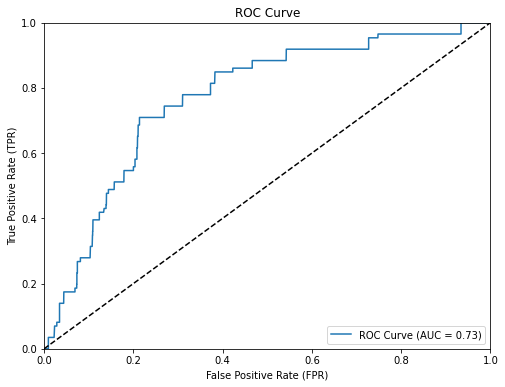

0.7704411386471306


In [123]:
# pd.DataFrame(objects_cols).rename(columns = {0: 'col_name'}).to_parquet('/home/mikhail/Downloads/Hackathon/objects.parquet')
groups = data['client_id']

# Создайте объект StratifiedGroupKFold и задайте количество фолдов
n_splits = 5  # Задайте нужное количество фолдов
sgkf = StratifiedGroupKFold(n_splits=n_splits)

# Проходите по каждому фолду
for fold, (train_idx, val_idx) in enumerate(sgkf.split(data_andrew, y, groups)):
    # Далее вы можете использовать train_idx и val_idx для разделения данных на обучающий и валидационный фолд
    train_data = data_andrew[['col2366', 'col2388', 'col2340', 'col2382','col2360','col2220', 'col2663', 'col2294']].iloc[train_idx]
    val_data = data_andrew[['col2366', 'col2388', 'col2340', 'col2382','col2360','col2220', 'col2663', 'col2294']].iloc[val_idx]

    scaler = StandardScaler()

    X_train = scaler.fit_transform(train_data) # выбери другое (например среднее)
    y_train = y[train_idx]#train_data['target']
    
    X_test = scaler.fit_transform(val_data)#.drop(need_columns, axis=1).fillna(-404) # выбери другое (например среднее)
    y_test = y[val_idx]#val_data['target']

    class_weights = {0: 5, 1: 95}

    # Create and train a logistic regression model with custom class weights
    model = LogisticRegression(class_weight=class_weights, solver='liblinear', max_iter=1000, penalty='l1')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion)
    print("Classification Report:\n", classification_rep)

    y_probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    roc_auc = roc_auc_score(y_test, y_probabilities)
    print(roc_auc)
    
    

    

    

    